In [1]:
import mne
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the subject information
subject_info = pd.read_csv('subject-info.csv')
subject_info.tail()


,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
31,Subject31,19,F,2012,19.88,1
32,Subject32,20,F,2011,13.00,1
33,Subject33,17,M,2010,21.47,1
34,Subject34,18,F,2010,31.00,1
35,Subject35,17,F,2010,12.18,1


In [3]:
# Find all the EDF files
all_file_path = glob('eeg-during-mental-arithmetic-tasks-1.0.0/*.edf')
print(len(all_file_path))

72


In [4]:
# Separate rest and task files
rest_file_path = [i for i in all_file_path if '_1' in os.path.basename(i)]
task_file_path = [i for i in all_file_path if '_2' in os.path.basename(i)]
print("len of rest_file_path:",len(rest_file_path))
print("len of task_file_path:",len(task_file_path))

len of rest_file_path: 36
len of task_file_path: 36


In [5]:
%%capture
import matplotlib.pyplot as plt
import mne
import numpy as np
# Define frequency bands
bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}

# Function to calculate PSD for a given frequency band
def calculate_psd(data, sfreq, n_fft):
    psds, freqs = mne.time_frequency.psd_array_welch(data, sfreq=sfreq, fmin=1, fmax=100, n_fft=n_fft)
    return psds, freqs

# Function to read and preprocess data
def read_data(file_path, l_freq, h_freq):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    data.filter(l_freq=l_freq, h_freq=h_freq)
    epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=1)
    array = epochs.get_data()
    return array, data.info['sfreq']

In [6]:
%%capture
# Load and preprocess data for each frequency band
rest_data_arrays = {band: [read_data(file, fmin, fmax) for file in rest_file_path] for band, (fmin, fmax) in bands.items()}
task_data_arrays = {band: [read_data(file, fmin, fmax) for file in task_file_path] for band, (fmin, fmax) in bands.items()}

# Set n_fft to be less than or equal to the signal length
n_fft = 2000

# Compute PSD for each frequency band
psd_rest = {band: [] for band in bands}
psd_task = {band: [] for band in bands}

for band in bands:
    for rest_data, sfreq in rest_data_arrays[band]:
        psds, freqs = calculate_psd(rest_data, sfreq=sfreq, n_fft=n_fft)
        psd_rest[band].append(psds)
    
    for task_data, sfreq in task_data_arrays[band]:
        psds, freqs = calculate_psd(task_data, sfreq=sfreq, n_fft=n_fft)
        psd_task[band].append(psds)

In [7]:
%%capture
# Function to average PSD values over the specified frequency bands
def average_psd_over_bands(psds_list, freqs, fmin, fmax):
    band_psds = []
    for psds in psds_list:
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        band_psds.append(np.mean(psds[:, :, freq_mask], axis=(0, 1)))  # Average across epochs and channels
    return np.array(band_psds)

# Calculate average PSD over bands for both rest and task conditions
psd_rest_avg = {band: average_psd_over_bands(psd_rest[band], freqs, fmin, fmax) for band, (fmin, fmax) in bands.items()}
psd_task_avg = {band: average_psd_over_bands(psd_task[band], freqs, fmin, fmax) for band, (fmin, fmax) in bands.items()}

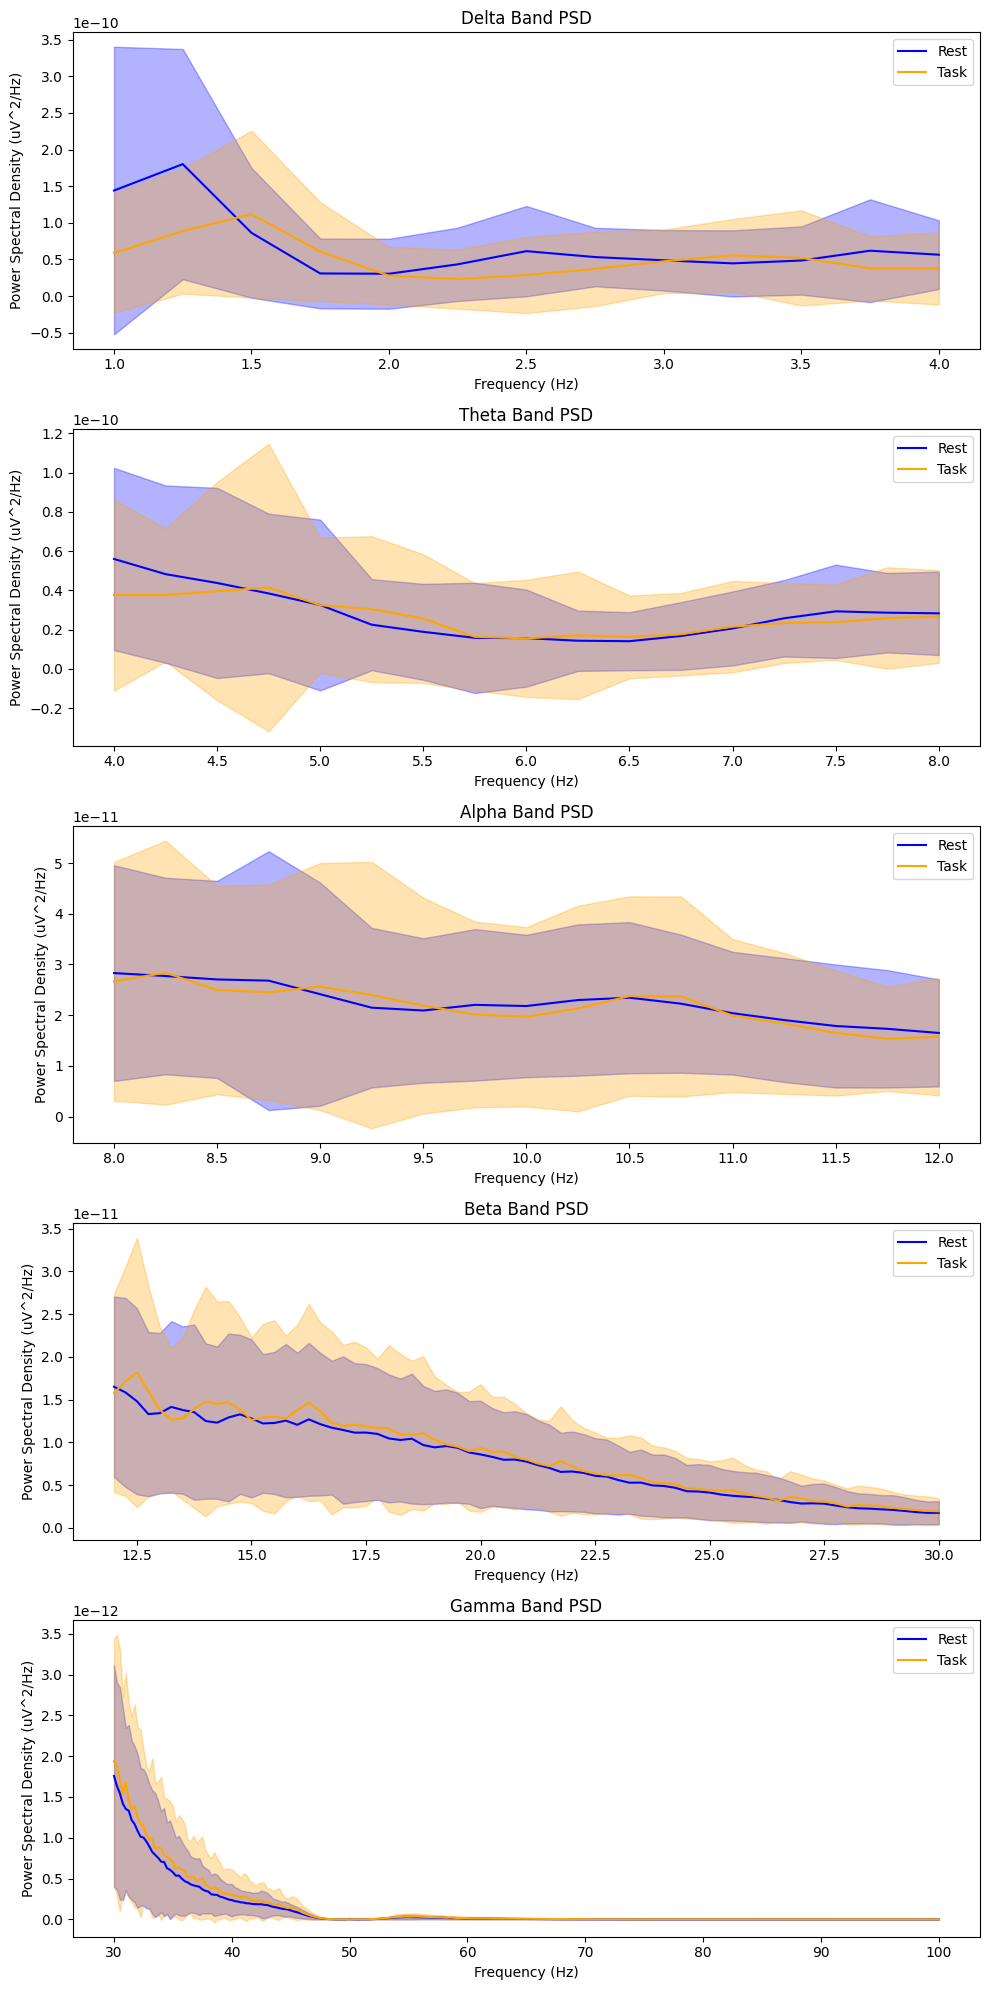

In [8]:
# Plot the PSD for each frequency band
fig, axes = plt.subplots(len(bands), 1, figsize=(10, 20))

for i, (band, (fmin, fmax)) in enumerate(bands.items()):
    ax = axes[i]
    
    # Compute mean and standard deviation for the band
    rest_mean_psd = np.mean(psd_rest_avg[band], axis=0)
    task_mean_psd = np.mean(psd_task_avg[band], axis=0)
    rest_std_psd = np.std(psd_rest_avg[band], axis=0)
    task_std_psd = np.std(psd_task_avg[band], axis=0)
    
    # Get the frequency values for the current band
    freqs_band = freqs[(freqs >= fmin) & (freqs <= fmax)]
    
    # Plot the mean PSD with the standard deviation as a shaded area
    ax.plot(freqs_band, rest_mean_psd, label='Rest', color='blue')
    ax.fill_between(freqs_band, rest_mean_psd - rest_std_psd, rest_mean_psd + rest_std_psd, color='blue', alpha=0.3)
    
    ax.plot(freqs_band, task_mean_psd, label='Task', color='orange')
    ax.fill_between(freqs_band, task_mean_psd - task_std_psd, task_mean_psd + task_std_psd, color='orange', alpha=0.3)
    
    ax.set_title(f'{band} Band PSD')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (uV^2/Hz)')
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Print shapes of PSD arrays to identify inconsistencies
"""for band in bands:
    print(f"Band: {band}")
    for psd in psd_rest_avg[band]:
        print(f"Rest PSD shape: {psd.shape}")
    for psd in psd_task_avg[band]:
        print(f"Task PSD shape: {psd.shape}")
"""

'for band in bands:\n    print(f"Band: {band}")\n    for psd in psd_rest_avg[band]:\n        print(f"Rest PSD shape: {psd.shape}")\n    for psd in psd_task_avg[band]:\n        print(f"Task PSD shape: {psd.shape}")\n'

In [10]:
# Ensure all PSD arrays have consistent shapes (3-dimensional)
def standardize_psd_shape(psd):
    if psd.ndim == 1:
        return psd[np.newaxis, np.newaxis, :]
    elif psd.ndim == 2:
        return psd[np.newaxis, :]
    return psd

# Apply standardization
psd_rest_avg_standardized = {band: [standardize_psd_shape(psd) for psd in psd_rest_avg[band]] for band in bands}
psd_task_avg_standardized = {band: [standardize_psd_shape(psd) for psd in psd_task_avg[band]] for band in bands}

# Determine the maximum length of PSD values again after standardization
max_length = max(max(psd.shape[-1] for psd in psd_rest_avg_standardized[band]) for band in bands)

# Function to pad PSD values to the maximum length
def pad_psd(psd, max_length):
    pad_width = max_length - psd.shape[-1]
    if pad_width > 0:
        return np.pad(psd, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    else:
        return psd

# Pad the PSD values for each band
psd_rest_avg_padded = {band: [pad_psd(psd, max_length) for psd in psd_rest_avg_standardized[band]] for band in bands}
psd_task_avg_padded = {band: [pad_psd(psd, max_length) for psd in psd_task_avg_standardized[band]] for band in bands}

# Create feature arrays and labels
X = []
y = []

# Labels: 0 for rest, 1 for task
for band in bands:
    X.extend(psd_rest_avg_padded[band])
    y.extend([0] * len(psd_rest_avg_padded[band]))
    X.extend(psd_task_avg_padded[band])
    y.extend([1] * len(psd_task_avg_padded[band]))

X = np.array(X)
y = np.array(y)

# Verify shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Shuffle the data
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of X: (360, 1, 1, 281)
Shape of y: (360,)


In [11]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (288, 1, 1, 281)
Shape of X_test: (72, 1, 1, 281)


In [12]:
# Reshape data for EEGNet
X_train_eegnet = X_train.reshape((X_train.shape[0], 1, X_train.shape[3], 1))
X_test_eegnet = X_test.reshape((X_test.shape[0], 1, X_test.shape[3], 1))

# Verify the shape after reshaping
print("Shape of X_train after reshaping:", X_train_eegnet.shape)
print("Shape of X_test after reshaping:", X_test_eegnet.shape)

Shape of X_train after reshaping: (288, 1, 281, 1)
Shape of X_test after reshaping: (72, 1, 281, 1)


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, DepthwiseConv2D, Activation, AveragePooling2D, Dropout, SeparableConv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight

# Function to pad PSD values to the maximum length
def pad_psd(psd, max_length):
    pad_width = max_length - psd.shape[-1]
    if pad_width > 0:
        return np.pad(psd, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    else:
        return psd

# Ensure all PSD arrays have consistent shapes (3-dimensional)
def standardize_psd_shape(psd):
    if psd.ndim == 1:
        return psd[np.newaxis, np.newaxis, :]
    elif psd.ndim == 2:
        return psd[np.newaxis, :]
    return psd

# Apply standardization and padding
psd_rest_avg_standardized = {band: [standardize_psd_shape(psd) for psd in psd_rest_avg[band]] for band in bands}
psd_task_avg_standardized = {band: [standardize_psd_shape(psd) for psd in psd_task_avg[band]] for band in bands}

# Determine the maximum length of PSD values
max_length = max(max(psd.shape[-1] for psd in psd_rest_avg_standardized[band]) for band in bands)

# Pad the PSD values for each band
psd_rest_avg_padded = {band: [pad_psd(psd, max_length) for psd in psd_rest_avg_standardized[band]] for band in bands}
psd_task_avg_padded = {band: [pad_psd(psd, max_length) for psd in psd_task_avg_standardized[band]] for band in bands}

# Create feature arrays and labels
X = []
y = []

for band in bands:
    X.extend(psd_rest_avg_padded[band])
    y.extend([0] * len(psd_rest_avg_padded[band]))
    X.extend(psd_task_avg_padded[band])
    y.extend([1] * len(psd_task_avg_padded[band]))

X = np.array(X)
y = np.array(y)

# Shuffle the data
X, y = shuffle(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for EEGNet
X_train_eegnet = X_train.reshape((X_train.shape[0], 1, X_train.shape[3], 1))
X_test_eegnet = X_test.reshape((X_test.shape[0], 1, X_test.shape[3], 1))

# Modify model architecture
def EEGNet(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (1, 10), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(DepthwiseConv2D((1, 5), padding='same'))
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 2)))
    model.add(Dropout(0.5))
    
    model.add(SeparableConv2D(16, (1, 10), padding='same'))  # Adjusted filter size
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build and compile EEGNet model
eegnet_model = EEGNet((1, max_length, 1), num_classes=2)
eegnet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the EEGNet model
history_eegnet = eegnet_model.fit(X_train_eegnet, y_train, epochs=100, batch_size=32, validation_data=(X_test_eegnet, y_test))

# Make predictions
y_pred = eegnet_model.predict(X_test_eegnet)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Print the classification report
print("Accuracy:", accuracy)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5702 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6943
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4569 - loss: 0.6963 - val_accuracy: 0.4167 - val_loss: 0.6949
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5716 - loss: 0.6893 - val_accuracy: 0.4167 - val_loss: 0.6955
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4856 - loss: 0.6954 - val_accuracy: 0.4167 - val_loss: 0.6961
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4740 - loss: 0.6967 - val_accuracy: 0.4167 - val_loss: 0.6959
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5352 - loss: 0.6958 - val_accuracy: 0.4167 - val_loss: 0.6963
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5777 - loss: 0.6897 - val_accuracy: 0.4167 - val_loss: 0.6969
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5497 - loss: 0.6905 - val_accuracy: 0.4167 - val_loss: 0.6974

In [14]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.42      1.00      0.59        30
           1       0.00      0.00      0.00        42

    accuracy                           0.42        72
   macro avg       0.21      0.50      0.29        72
weighted avg       0.17      0.42      0.25        72



In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_train and X_test are already reshaped correctly as (number_of_samples, 1, 1, 281)
# If not, ensure X_train and X_test are in the correct shape before this step

# Verify the shape of X_train and X_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (288, 1, 1, 281)
Shape of X_test: (72, 1, 1, 281)


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already prepared and correctly shaped

# Define the input shape and number of classes
input_shape = (1, 1, 281)
num_classes = len(np.unique(y_train))

# Function to build TSCeption model
def TSCeption(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=(1, 5), padding='same')(inputs)  # Use Conv2D for 2D input
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, kernel_size=(1, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build TSCeption model
tception_model = TSCeption(input_shape, num_classes)

# Compile TSCeption model
tception_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train TSCeption model
history = tception_model.fit(X_train, y_train,
                             epochs=50,
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=1)

# Evaluate TSCeption model
y_pred = tception_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4794 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5230 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6956
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5318 - loss: 0.6923 - val_accuracy: 0.4167 - val_loss: 0.6974
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5732 - loss: 0.6899 - val_accuracy: 0.4167 - val_loss: 0.6988
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5572 - loss: 0.6901 - val_accuracy: 0.4167 - val_loss: 0.6989
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5088 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6985
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5373 - loss: 0.6913 - val_accuracy: 0.4167 - val_loss: 0.6991
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5158 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6997
Epoch 9

In [17]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Test Accuracy: 0.4167
Precision: 0.1736
Recall: 0.4167
F1-score: 0.2451
